# 4.利用隐变量解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

## 2. 隐层表示提取

1. 提取隐变量

In [3]:
velovgi_model = velovgi.tl.VELOVGI.load("model/500_epoch(max_epochs=500)", adata=adata, use_gpu=True) # 需要根据gpu进行调换
latent_umap_key = "X_latent_umap"
velovgi.tl.get_latent_umap(adata, velovgi_model, latent_umap_key=latent_umap_key, random_seed=1000)

INFO     File model/500_epoch(max_epochs=500)/model.pt already downloaded                                          


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'X_latent', 'X_latent_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. 隐变量的降维速率图

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


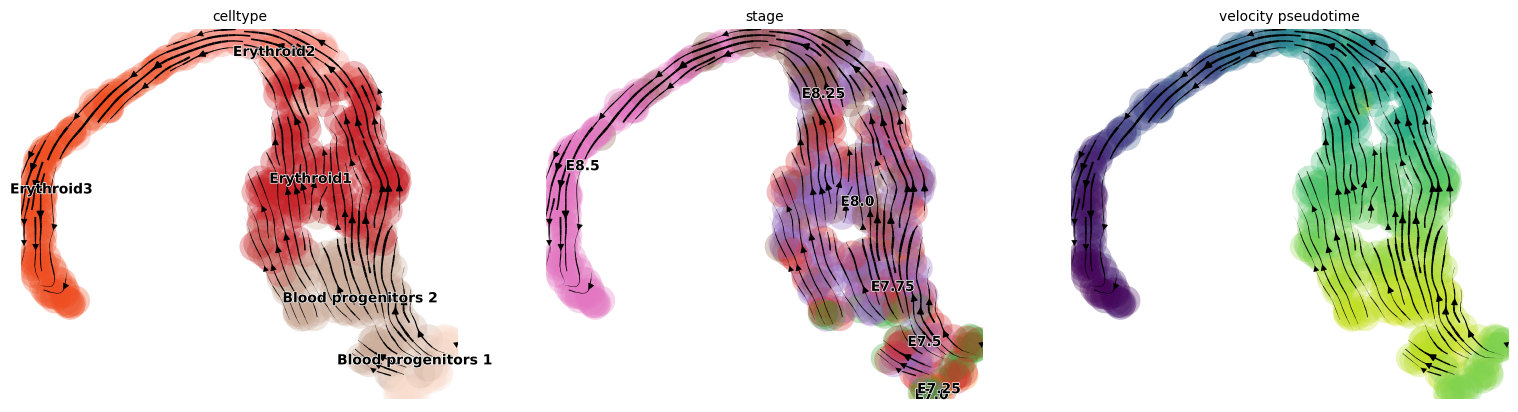

In [4]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, pseudotime_key], basis=latent_umap_key, colorbar=False)

## 2. 利用网络权重理解

Text(70.72222222222221, 0.5, 'Latent Dimensions')

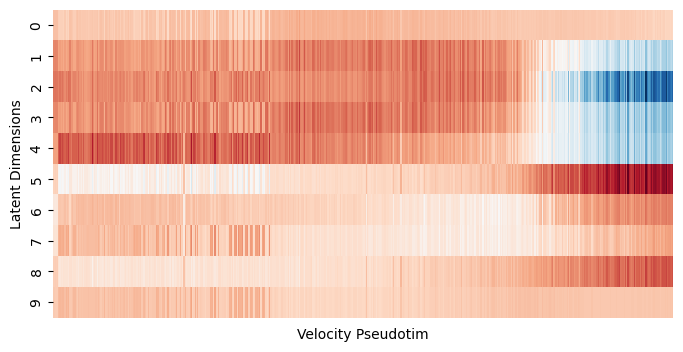

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (8, 4)
plt.figure(figsize=figsize)

# 隐变量排序
sorted_index = adata.obs["velocity_pseudotime"].sort_values().index
sorted_adata = adata[sorted_index]
latent_reprentation = sorted_adata.obsm["X_latent"]

# 显示聚类相关的颜色
color_dict = dict(zip(adata.obs[cluster_key].cat.categories, adata.uns["%s_colors"%cluster_key]))
color_list = adata.obs[cluster_key].apply(lambda x: color_dict[x]).to_numpy()

# 绘制隐变量热图
# sns.clustermap(latent_reprentation, row_cluster=False, col_cluster=False, row_colors=color_list, cbar_pos=(1, 0.05, 0.05, 0.3), cmap="RdBu_r")
sns.heatmap(latent_reprentation.T, cmap="RdBu_r", cbar=False) # 不要颜色条
plt.xticks([])
plt.xlabel("Velocity Pseudotim")
plt.ylabel("Latent Dimensions")

2. 编码器的特征提取整体与部分权重可视化

<AxesSubplot: >

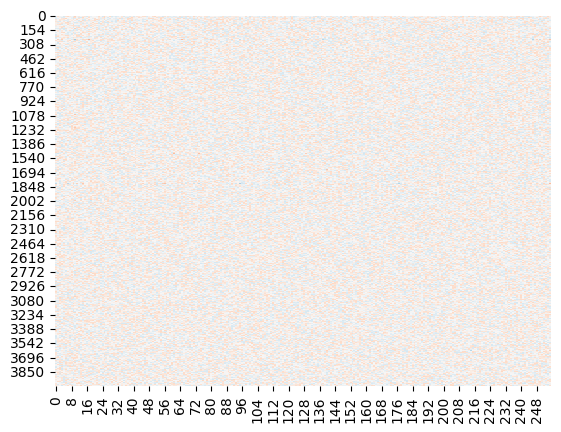

In [6]:
import numpy as np

gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
sns.heatmap(gcn_weight.T, cmap="RdBu_r", cbar=False)

[1645, 1644, 304, 305, 306]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Hbb-y,0.141131,-0.050409,0.111831,-0.050684,0.016601,-0.090268,0.109871,0.074930,0.127443,-0.109549,...,-0.059395,-0.116186,-0.042409,-0.006662,-0.110116,-0.087451,-0.103761,0.074574,-0.136487,-0.101862
Hbb-bh1,-0.020076,0.022067,-0.015363,-0.016585,0.077750,-0.019689,-0.057503,0.037730,-0.027252,0.034253,...,-0.035885,0.015135,0.007901,-0.067919,-0.000121,-0.011399,-0.006056,0.012418,0.011986,0.022721
Hba-x,0.026899,-0.053912,0.003488,-0.030292,0.000287,0.006401,-0.045770,-0.002558,0.019759,-0.027210,...,-0.008550,-0.008926,-0.050585,-0.093731,0.000216,-0.022922,-0.006548,0.035506,-0.010862,-0.059260
Hba-a1,0.040776,0.023085,0.025088,0.012536,0.027404,0.000080,-0.003018,0.027711,-0.002172,-0.032415,...,0.012104,-0.015977,-0.036133,-0.009868,0.010452,0.005841,-0.045951,-0.006791,-0.013710,0.014992
Hba-a2,-0.006093,-0.030150,0.012965,-0.033788,0.018386,0.018151,0.040815,0.011531,0.038296,0.001467,...,-0.044572,-0.019887,-0.027130,0.025264,-0.009571,-0.012708,0.014487,0.038332,0.005468,-0.010024


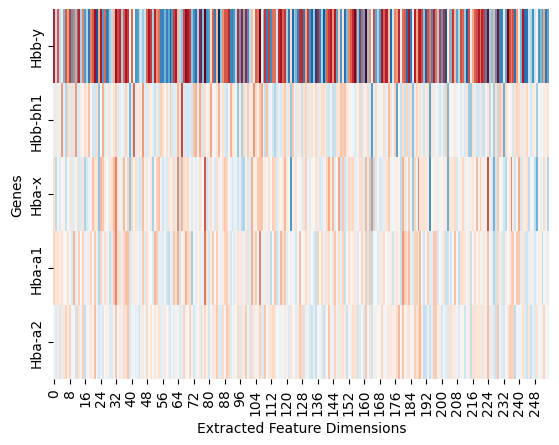

In [7]:
import pandas as pd

n_top = 5
feature_gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
# index_list = list(np.argsort(feature_gcn_weight.mean(axis=0))[::-1][:n_top])  # 权重最大的前几个
index_list = list(np.argsort(np.abs(feature_gcn_weight).mean(axis=0))[::-1][:n_top])  # 权重绝对值最大的前几个
print(index_list)

gene_index_list = []
for index in index_list:
    if index > 2000:
        index = index-2000
    gene_index_list.append(index)

# 添加基因名
gene_name_list = list(adata.var.iloc[gene_index_list].index)
feature_df = pd.DataFrame(gcn_weight[:, gene_index_list].T)
feature_df.index = gene_name_list

sns.heatmap(feature_df, cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

2. 提取与Hbb-y相关性很强的特征

In [8]:
top_n = 2
positive_feature_index_list = list(np.argsort(feature_df.loc["Hbb-y"])[::-1][:top_n]) # 与Hbb-y相关的特征
negtive_feature_index_list = list(np.argsort(feature_df.loc["Hbb-y"])[:top_n]) # Hbb-y负相关的特征

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

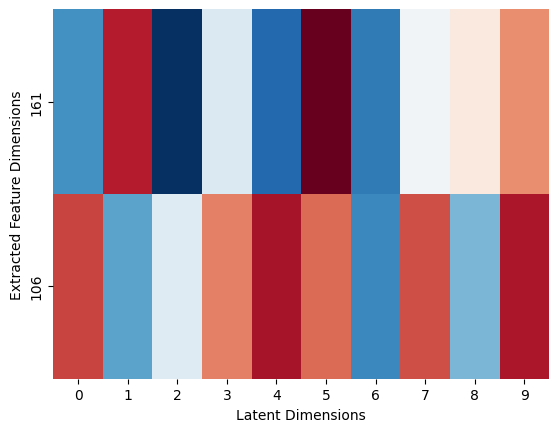

In [9]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, positive_feature_index_list].T)
df.index = positive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

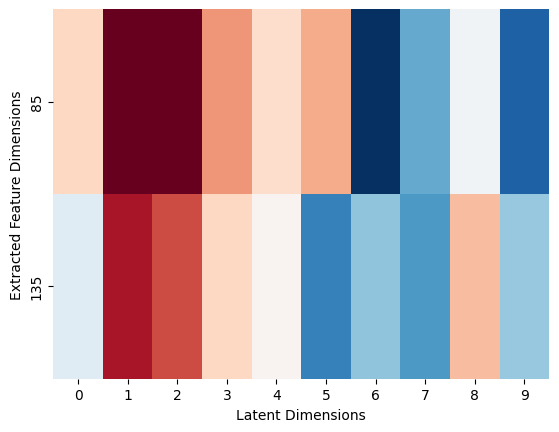

In [10]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, negtive_feature_index_list].T)
df.index = negtive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")